In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
df = pd.read_csv('ord_vol.csv')
df['beg_month'] = pd.to_datetime(df['beg_month'])

In [3]:
df.dtypes["ro"] in ['int64', 'datetime64[ns]']

True

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32724 entries, 0 to 32723
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  32724 non-null  int64         
 1   beg_month   32724 non-null  datetime64[ns]
 2   product     32724 non-null  object        
 3   region      32724 non-null  object        
 4   district    32724 non-null  object        
 5   terr        32724 non-null  object        
 6   ro          32724 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.7+ MB


In [5]:
df

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
...,...,...,...,...,...,...,...
32719,32719,2021-01-01,HOME,A9,R906,TSV1138,44
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67


In [6]:
# flake8: noqa: E501

import numpy as np
from numpy.core.fromnumeric import mean
import pandas as pd
from pandas.core.indexes.api import get_objs_combined_axis
import pmdarima
from datetime import datetime
import typing
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # upgrade to the the latest scikit-learn pip install -U scikit-learn
import random

## Changes to be made
## 1 would like to add an argument 

class TSFM(object):
    def __init__(self,
                 df: pd.core.frame.DataFrame,
                 n_pred_period: int,
                 date_variable: typing.Union[int, str],
                 value_variable: typing.Union[int, str],
                 target_variable: str,
                 stop_date: str,         # stop date of train set, to split df to train and test sets
                 section_list: list = None,
                 cycle_length: int = 12,
                 alpha: float = 0.05,
                 stepwise: bool = True,
                 start_order: tuple = (0, 1, 0),
                 max_order: tuple = (4, 2, 5),
                 start_seasonal_order: tuple = (0, 1, 0),
                 max_seasonal_order: tuple = (2, 2, 4)):
        self.target_variable = target_variable
        # self.n_pred_period = n_pred_period + abs((datetime.strptime(df[date_variable].to_numpy()[-1])  - datetime.strptime(stop_date, "%Y-%m-%d")).days)
        self.n_pred_period = n_pred_period
        self.stop_date = stop_date
        self.cycle_length = cycle_length
        self.alpha = alpha
        self.stepwise = stepwise
        self.start_order = start_order
        self.max_order = max_order
        self.start_seasonal_order = start_seasonal_order
        self.max_seasonal_order = max_seasonal_order

        self.is_log_transformed_dict = dict()
        self.pred_dict = dict()
        self.pred_ic_dict = dict()
        self.adjusted_pred_dict = dict()
        self.adjusted_pred_ic_dict = dict()

        # train and test df must have date as index, and 2 columns: sections(e.g. territory) and values(e.g. order_volume)
        if type(date_variable) is int:
            date_variable = df.columns[date_variable]
        if type(value_variable) is int:
            value_variable = df.columns[value_variable]
        # Select relevant columns for train and test df, create empty pred df
        self.columns = [date_variable, target_variable, value_variable]
        df[self.columns[0]] = pd.to_datetime(df[self.columns[0]])
        

        self.df = df.copy()

        # keys: sections(territories), value: list(train, test, pred), for easy storing and fetching data
        self.df_dict = dict()
        self.model_dict = dict()
        self.adjusted_model_dict = dict()

        # Iterate through the unique sections
        self.section_list = section_list
        if self.section_list is None:
            self.section_list = df[target_variable].unique()
        for section in self.section_list:
            self.is_log_transformed_dict[section] = False
            models = self.__train_models(section = section, is_log_transformed=False)
            if self.__have_negative_prediction(models=models):
                print("Negative prediction detected in", section)
                self.is_log_transformed_dict[section] = True
                models = self.__train_models(section = section, is_log_transformed=True)
            (arima_model, adjusted_arima_model) = models
            self.model_dict[section] = arima_model
            self.adjusted_model_dict[section] = adjusted_arima_model
            self.pred_dict[section], self.pred_ic_dict[section] = self.__get_pred_data(section=section, return_conf_int=True, is_adjusted=False)
            self.adjusted_pred_dict[section], self.adjusted_pred_ic_dict[section] = self.__get_pred_data(section=section, return_conf_int=True, is_adjusted=True)

            # print("Inspecting", section, "...")
            # temp_actual_df = self.get_actual_data(section=section, is_adjusted=False)
            # if temp_actual_df.shape[0] >= 2 * cycle_length:
            #     # train actual data
            #     print("Training", temp_actual_df.shape[0], "actual records ...")
            #     arima_model = pmdarima.auto_arima(temp_actual_df[temp_actual_df.columns[-1]],
            #                                     start_p=start_p, start_P=start_P,
            #                                     start_q=start_q, start_Q=start_Q,
            #                                     d=start_d, D=start_D,
            #                                     max_p=max_p, max_P=max_P,
            #                                     max_d=max_d, max_D=max_D,
            #                                     max_q=max_q, max_Q=max_Q,
            #                                     trace=True, m=cycle_length, stepwise=stepwise)
            #     self.model_dict[section] = arima_model

            #     temp_adjusted_actual_df = self.get_actual_data(section=section, is_adjusted=True)
            #     # train adjusted actual data
            #     print("Training", temp_adjusted_actual_df.shape[0], "adjusted actual records ...")
            #     arima_model = pmdarima.auto_arima(temp_adjusted_actual_df[temp_adjusted_actual_df.columns[-1]],
            #                                     start_p=start_p, start_P=start_P,
            #                                     start_q=start_q, start_Q=start_Q,
            #                                     d=start_d, D=start_D,
            #                                     max_p=max_p, max_P=max_P,
            #                                     max_d=max_d, max_D=max_D,
            #                                     max_q=max_q, max_Q=max_Q,
            #                                     trace=True, m=cycle_length, stepwise=stepwise)
            #     self.adjusted_model_dict[section] = arima_model
            # else:
            #     print("Number of data points in Section", section, "is too small (" + str(
            #         temp_actual_df.shape[0]) + ". Must be at least twice the declared cycle length.")

    # DF Getters--------------------------------------------------------------
    def get_actual_data(self, section: str, is_adjusted: bool, is_log_transformed: bool = False) -> pd.core.frame.DataFrame:
        agg_df = self.df[self.columns].groupby(self.columns[0:2], as_index=False).sum().copy()
        agg_df = agg_df.query(self.columns[1] + "==" + "'" + section + "'")[[self.columns[0], self.columns[2]]]
        agg_df.set_index(self.columns[0], inplace=True)
        agg_df = TSFM.to_monthly(agg_df)
        if is_adjusted:
            agg_df = self.anomaly_filter(agg_df, alpha = self.alpha)
        if is_log_transformed:
            agg_df = TSFM.log_transform(agg_df)
        return agg_df

    def get_train_data(self, section: str):  ## added stop date
        actual_df = self.get_actual_data(section, is_adjusted=False)
        return actual_df.iloc[lambda x: x.index <= self.stop_date].copy()

    def get_test_data(self, section: str, ):
        actual_df = self.get_actual_data(section)
        return actual_df.iloc[lambda x: x.index > self.stop_date].copy()

    def get_pred_data(self, section: str, return_conf_int: bool = False, is_adjusted: bool = True):
        pred, ic = None, None
        if is_adjusted:
            pred, ic = self.adjusted_pred_dict[section], self.adjusted_pred_ic_dict[section]
        else:
            pred, ic = self.pred_dict[section], self.pred_ic_dict[section]
        if return_conf_int:
            return pred, ic
        return pred

    def __get_pred_data(self, section: str, return_conf_int: bool = False, is_adjusted: bool = True):
        actual_df = self.get_actual_data(section, False)
        model = self.get_model(section=section, is_adjusted=is_adjusted)
        if model is None:
            print("Model of", section, "section was not initiated. Might due to insufficient training data.")
            return None
        print(model.predict(self.n_pred_period, return_conf_int=return_conf_int))
        pred, conf_int = model.predict(self.n_pred_period, return_conf_int=True)

        temp_pred_df = pd.DataFrame(
            data={
                self.columns[0]: pd.date_range(max(actual_df.index),freq='MS',periods=self.n_pred_period+1)[1:],
                self.columns[1]: [section for x in range(len(pred))],
                self.columns[-1]: pred})  # Use numbers inplace of future dates for now)
        temp_pred_df = temp_pred_df[[self.columns[0], self.columns[2]]]
        temp_pred_df.set_index(self.columns[0], inplace=True)
        if self.is_log_transformed_dict[section]:
            temp_pred_df = self.exp_transform(temp_pred_df)
        if return_conf_int:
            return temp_pred_df.copy(), conf_int
        return temp_pred_df.copy()

    def get_pred_df(self):
        '''
        function to be called in the backend to get pred data from all sections
        '''
        return_df = pd.DataFrame(columns=self.columns)
        for section in self.section_list:
            actual_pred = self.get_pred_data(section, is_adjusted=False)
            adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)
            pred = pd.DataFrame(data={actual_pred.columns[0]: actual_pred[actual_pred.columns[0]].to_numpy(), "value2": adjusted_actual_pred[adjusted_actual_pred.columns[0]].to_numpy()},
                                index = actual_pred.index)
            pred.reset_index(inplace=True)
            pred[self.target_variable] = [section for x in range(pred.shape[0])]
            return_df = return_df.append(pred, ignore_index=True)
        return_df.sort_values(by=[self.columns[1], self.columns[0]], inplace=True, ignore_index=True)
        return return_df

    # Model Getters----------------------------------------------------------
    def get_model(self, section: str, is_adjusted: bool = True):
        if is_adjusted:
            return self.adjusted_model_dict[section]
        return self.model_dict[section]
    
    # Plot Function-----------------------------------------------------------
    def plot(self, section: str):
        actual = self.get_actual_data(section, is_adjusted=False)
        adjusted_actual, conf_int_df = self.anomaly_filter(actual, return_conf_int=True, alpha = self.alpha)
        # pred, ci = self.get_pred_data(section, return_conf_int=True)

        actual_pred = self.get_pred_data(section, is_adjusted=False)
        adjusted_actual_pred = self.get_pred_data(section, is_adjusted=True)

        fig, ax = plt.subplots(figsize=(14,6))
        ax.plot(actual.index, actual[actual.columns[0]].to_numpy(),label="Actual")   #Actuals This should come from original DS (all actuals)
        ax.plot(adjusted_actual.index, adjusted_actual[adjusted_actual.columns[0]].to_numpy(),'-g', label="Adjusted Actual")   
        # ax.plot(pred.index, pred[pred.columns[0]], '-r',alpha=0.75,label="Forecast")  ## Pred
        ax.fill_between(conf_int_df.index, conf_int_df.iloc[:, 0], conf_int_df.iloc[:, 1],alpha=0.3, color='b')  ## Conf intervals
        
        ax.plot(actual_pred.index, actual_pred.iloc[:, 0], '--b',alpha=0.75,label="Actual Forecast")
        ax.plot(adjusted_actual_pred.index, adjusted_actual_pred.iloc[:, 0], '--g',alpha=0.75,label="Adjusted Actual Forecast")
        plt.title('Forecast Model')
        plt.xlabel('Year')
        plt.ylabel('Forecast Accurary')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())

        plt.legend()
        plt.show()

    def anomaly_filter(self,
                       df: pd.core.frame.DataFrame,
                       return_conf_int: bool = False, 
                       n_rolling_period: int = 12,
                       alpha: float = 0.05):
        print("Applying anomaly filter...")
        df = df.copy()
        train = df.iloc[lambda x: x.index <= self.stop_date]
        stop_date = max(train.index)
        returning_ic_list = list()
        (start_p, start_d, start_q) = self.start_order
        (max_p, max_d, max_q) = self.max_order
        (start_P, start_D, start_Q) = self.start_seasonal_order
        (max_P, max_D, max_Q) = self.max_seasonal_order
        for i in range(train.shape[0], df.shape[0], n_rolling_period):
            arima_model = pmdarima.auto_arima(train[train.columns[0]],
                                                start_p=start_p, start_P=start_P,
                                                start_q=start_q, start_Q=start_Q,
                                                d=start_d, D=start_D,
                                                max_p=max_p, max_P=max_P,
                                                max_d=max_d, max_D=max_D,
                                                max_q=max_q, max_Q=max_Q,
                                                trace=True, m=self.cycle_length, stepwise=self.stepwise)
            temp_actual_df = df.iloc[i:min(i+n_rolling_period, df.shape[0]), :].copy()
            temp_pred, ic_list = arima_model.predict(n_rolling_period, return_conf_int=True, alpha=alpha)
            for j in range(temp_actual_df.shape[0]):
                temp_actual = temp_actual_df.iloc[j, 0]
                ic = ic_list[j]
                if temp_actual < ic[0] or temp_actual > ic[1]:
                    temp_actual_df.iloc[j, 0] = temp_pred[j]
            train = train.append(temp_actual_df)
            returning_ic_list = returning_ic_list + ic_list.tolist()
        train[train.columns[0]] = train[train.columns[0]].astype('float')
        train = train.asfreq('MS')
        if return_conf_int:
            returning_ic_list = np.array(returning_ic_list)
            ic_df = pd.DataFrame(
                data={
                    'lower': returning_ic_list[:, 0],
                    'upper': returning_ic_list[:, 1],
                },
                index=pd.date_range(stop_date,freq='MS',periods=returning_ic_list.shape[0]+1)[1:]
            )
            return train.copy(), ic_df
        return train.copy()
    
    def cross_validate(self,section: str, is_adjusted: bool):
        actual_df = self.get_actual_data(section, is_adjusted)
        actual_arr = actual_df[actual_df.columns[0]].to_numpy(dtype='float')
        trained_model = self.get_model(section, is_adjusted)
        order = trained_model.order
        seasonal_order = trained_model.seasonal_order

        model = pmdarima.ARIMA(order = order, seasonal_order=seasonal_order)
        MAE = list()
        MAPE = list()
        tscv = TimeSeriesSplit(10)
        for train_index, test_index in tscv.split(X=actual_df.index):
            if len(train_index) >= 24:
                print("train_index = {}".format(train_index))
                print("test_index = {}".format(test_index))
                train = actual_arr[train_index]
                test = actual_arr[test_index]
                print("train = {}".format(train))
                print("test = {}".format(test))
                model.fit(train)
                pred = model.predict(len(test))
                mae = mean_absolute_error(test, pred)
                mape = mean_absolute_percentage_error(test, pred)
                MAE.append(mae)
                MAPE.append(mape)
                
                print("MAE = {}".format(mae))
                print("MAPE = {}".format(mape))
                print("-"*50)
            else:
                pass
        print("MAE = {}".format(MAE))
        print("MAPE = {}".format(MAPE))
        print("Average MAE = {}".format(np.mean(MAE)))
        print("Average MAPE = {}".format(np.mean(MAPE)))

    def __train_models(self, section: str, is_log_transformed: bool) -> tuple:
        (start_p, start_d, start_q) = self.start_order
        (max_p, max_d, max_q) = self.max_order
        (start_P, start_D, start_Q) = self.start_seasonal_order
        (max_P, max_D, max_Q) = self.max_seasonal_order

        print("Inspecting", section, "...")
        temp_actual_df = self.get_actual_data(section=section, is_adjusted=False, is_log_transformed=is_log_transformed)
        if temp_actual_df.shape[0] >= 2 * self.cycle_length:
            # train actual data
            print("Training", temp_actual_df.shape[0], "actual records ...")
            arima_model = pmdarima.auto_arima(temp_actual_df[temp_actual_df.columns[-1]],
                                            start_p=start_p, start_P=start_P,
                                            start_q=start_q, start_Q=start_Q,
                                            d=start_d, D=start_D,
                                            max_p=max_p, max_P=max_P,
                                            max_d=max_d, max_D=max_D,
                                            max_q=max_q, max_Q=max_Q,
                                            trace=True, m=self.cycle_length, stepwise=self.stepwise)

            temp_adjusted_actual_df = self.get_actual_data(section=section, is_adjusted=True, is_log_transformed=is_log_transformed)
            # train adjusted actual data
            print("Training", temp_adjusted_actual_df.shape[0], "adjusted actual records ...")
            adjusted_arima_model = pmdarima.auto_arima(temp_adjusted_actual_df[temp_adjusted_actual_df.columns[-1]],
                                            start_p=start_p, start_P=start_P,
                                            start_q=start_q, start_Q=start_Q,
                                            d=start_d, D=start_D,
                                            max_p=max_p, max_P=max_P,
                                            max_d=max_d, max_D=max_D,
                                            max_q=max_q, max_Q=max_Q,
                                            trace=True, m=self.cycle_length, stepwise=self.stepwise)
            return arima_model, adjusted_arima_model
        print("Number of data points in Section", section, "is too small (" + str(
            temp_actual_df.shape[0]) + ". Must be at least twice the declared cycle length.")
        return None, None

    def __have_negative_prediction(self, models: tuple) -> bool:
        (model, adjusted_model) = models
        if model is None or adjusted_model is None:
            return False
        pred = model.predict(self.n_pred_period)
        adjusted_pred = adjusted_model.predict(self.n_pred_period)
        if min(min(pred), min(adjusted_pred)) < 0:
            return True
        return False
        

    @staticmethod
    def log_transform(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''
        df has 1 value column and has dates as indeces
        '''
        value_arr = df.loc[:, df.columns[0]].values.copy()
        value_arr[value_arr < 1] = 1 # avoid negative results from transformation
        value_arr = np.log(value_arr)
        return  pd.DataFrame(index=df.index, data={df.columns[0]: value_arr})
    
    @staticmethod
    def exp_transform(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        '''
        df has 1 value column and has dates as indeces
        '''
        value_arr = df.loc[:, df.columns[0]].values.copy()
        value_arr = np.exp(value_arr)
        return  pd.DataFrame(index=df.index, data={df.columns[0]: value_arr})



    @classmethod
    def to_monthly(cls, df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
        return df.resample('MS').sum()

    


In [7]:
tsfm = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='product', value_variable='ro', stop_date="2020-03-01", section_list=["HOME", "ACUTE"])

Inspecting HOME ...
Training 49 actual records ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=604.245, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=607.707, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=607.531, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=606.084, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=605.989, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=607.812, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=605.923, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=605.856, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=606.135, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=605.924, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.612 seconds
Applying anomaly filter...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=412.762, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]        

In [ ]:
tsfm.get_pred_df()

In [11]:
tsfm.get_pred_data("HOME", is_adjusted=True, return_conf_int=True)

(                      ro
 beg_month               
 2021-02-01  12094.423928
 2021-03-01  12784.423928
 2021-04-01  12926.980436
 2021-05-01  13908.652157
 2021-06-01  12659.423928
 2021-07-01  14138.423928
 2021-08-01  13647.423928
 2021-09-01  12670.956263
 2021-10-01  14543.423928
 2021-11-01  12597.423928
 2021-12-01  13007.423928
 2022-01-01  13208.903606
 2022-02-01  12223.847855
 2022-03-01  12913.847855
 2022-04-01  13056.404363
 2022-05-01  14038.076085
 2022-06-01  12788.847855
 2022-07-01  14267.847855
 2022-08-01  13776.847855
 2022-09-01  12800.380191
 2022-10-01  14672.847855
 2022-11-01  12726.847855
 2022-12-01  13136.847855
 2023-01-01  13338.327534,
 array([[11239.11268299, 12949.73517211],
        [11897.51143425, 13671.33642084],
        [12009.55457137, 13844.40629992],
        [12961.6956313 , 14855.6086833 ],
        [11683.83020687, 13635.01764822],
        [13135.00997832, 15141.83787678],
        [12616.94054622, 14677.90730888],
        [11614.09655392, 1372

Applying anomaly filter...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.176, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=370.356, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=369.066, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=370.360, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=372.348, Time=0.17 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=369.964, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=370.841, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.031 seconds


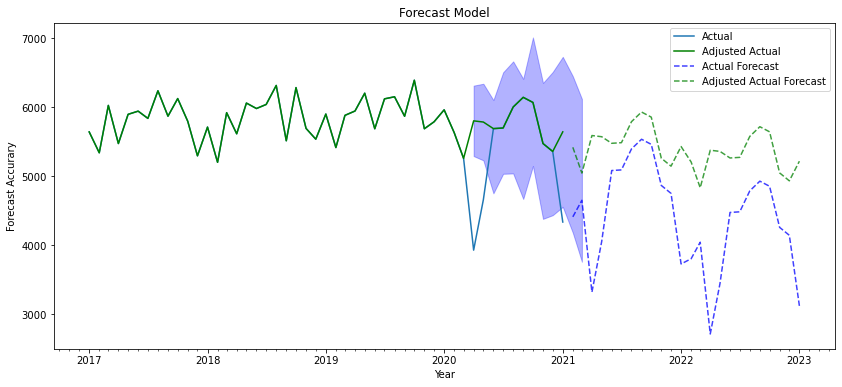

In [12]:
tsfm.plot("ACUTE")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=375.176, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=370.356, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=369.066, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=370.360, Time=0.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=372.348, Time=0.28 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=369.964, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=370.841, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.414 seconds
[4410.48449174 4649.98295706 3320.98295706 4050.98295706 5080.98295706
 5089.98295706 5393.98295706 5533.98295706 5459.98295706 4864.98295706
 4749.98295706 3727.9829570

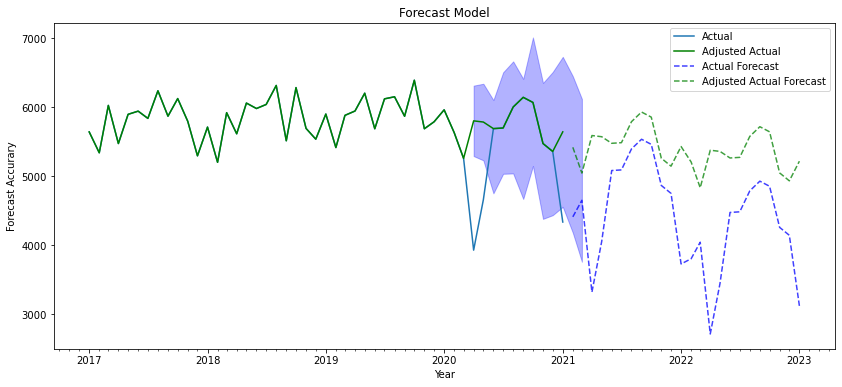

In [27]:
tsfm.plot("ACUTE")

In [8]:
tsfm.cross_validate("HOME", False)

train_index = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
test_index = [25 26 27 28]
train = [11260. 10906. 12657. 11245. 12505. 13015. 12051. 13442. 12377. 12783.
 12226. 11993. 11990. 10944. 12720. 12085. 13223. 13027. 13266. 14358.
 12463. 14154. 12756. 11957. 12493.]
test = [11554. 12903. 12931. 13587.]
MAE = 217.79166666666697
MAPE = 0.017085450471026335
--------------------------------------------------
train_index = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
test_index = [29 30 31 32]
train = [11260. 10906. 12657. 11245. 12505. 13015. 12051. 13442. 12377. 12783.
 12226. 11993. 11990. 10944. 12720. 12085. 13223. 13027. 13266. 14358.
 12463. 14154. 12756. 11957. 12493. 11554. 12903. 12931. 13587.]
test = [12418. 13355. 13787. 12452.]
MAE = 582.3125
MAPE = 0.044821298696230555
--------------------------------------------------
train_index = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 2

In [56]:
tsfm.cross_validate("HOME", True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=412.762, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=415.533, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=414.340, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=414.748, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=414.762, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=416.718, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=413.543, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=412.348, Time=0.06 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=414.340, Time=0.18 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=413.196, Time=0.07 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=412.036, Time=0.09 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=413.947, Time=0.22 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=413.947, Time=0.19 sec
 ARIMA(0,1,2)(1,1,1)[12]             

In [26]:
df.tail()

,Unnamed: 0,beg_month,product,region,district,terr,ro
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67
32723,32723,2021-01-01,HOME,A9,R906,TSV1148,31
32724,32724,2021-12-01,HOME,A7,R707,TSV1103,1


In [27]:
df = df.groupby(['date','prod','region','district','terr']).ro.count().reset_index()
# remove glitch in data
df =  df[df['date'] != df['date'].max()]

KeyError: 'date'

In [31]:
df.query("product == 'HOME'")

,Unnamed: 0,beg_month,product,region,district,terr,ro
461,461,2017-01-01,HOME,A0,R001,TSV1115,22
462,462,2017-01-01,HOME,A0,R001,TSV1196,31
463,463,2017-01-01,HOME,A1,R101,TSV1001,34
464,464,2017-01-01,HOME,A1,R101,TSV1165,85
465,465,2017-01-01,HOME,A1,R101,TSV1173,62
...,...,...,...,...,...,...,...
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67
32723,32723,2021-01-01,HOME,A9,R906,TSV1148,31


In [10]:
df.head(327210)

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
...,...,...,...,...,...,...,...
32719,32719,2021-01-01,HOME,A9,R906,TSV1138,44
32720,32720,2021-01-01,HOME,A9,R906,TSV1142,30
32721,32721,2021-01-01,HOME,A9,R906,TSV1145,48
32722,32722,2021-01-01,HOME,A9,R906,TSV1147,67


In [19]:
df.iloc[12, 1]

Timestamp('2017-01-01 00:00:00')

In [17]:
df.head(14)

,Unnamed: 0,beg_month,product,region,district,terr,ro
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,30
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,31
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,24
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,37
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,17
5,5,2017-01-01,ACUTE,A1,R102,TMV1009,26
6,6,2017-01-01,ACUTE,A1,R102,TMV1010,27
7,7,2017-01-01,ACUTE,A1,R102,TMV2010,8
8,8,2017-01-01,ACUTE,A1,R103,TMV1004,15
9,9,2017-01-01,ACUTE,A1,R103,TMV1020,20


In [31]:
pd.DataFrame({"A": [1, 2]})["A"].to_numpy()

array([1, 2], dtype=int64)

In [8]:
tsfm.get_model("ACUTE", True)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [9]:
tsfm.get_model("ACUTE", False)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

# ----------------------------

In [3]:
import pandas as pd
import numpy as np
import datetime

In [4]:
df = pd.read_csv('test_orders.csv')
df['beg_month'] = pd.to_datetime(df['beg_month'])

In [5]:
df

,Unnamed: 0,beg_month,prod,region,district,terr,order,test
0,0,2017-01-01,ACUTE,A1,R101,TMV1001,659072116,6.590721e+08
1,1,2017-01-01,ACUTE,A1,R101,TMV1002,681040689,6.810407e+08
2,2,2017-01-01,ACUTE,A1,R101,TMV1003,527196419,5.271964e+08
3,3,2017-01-01,ACUTE,A1,R101,TMV2001,812866909,8.128669e+08
4,4,2017-01-01,ACUTE,A1,R102,TMV1007,373438031,3.734380e+08
...,...,...,...,...,...,...,...,...
22026,22298,2020-12-01,HOME,A9,R906,TSV1138,1645334842,1.776640e+09
22027,22299,2020-12-01,HOME,A9,R906,TSV1142,1037867905,1.312286e+09
22028,22300,2020-12-01,HOME,A9,R906,TSV1145,1619883791,1.782534e+09
22029,22301,2020-12-01,HOME,A9,R906,TSV1147,1898723247,1.596377e+09


In [11]:
tsfm2 = TSFM(df=df, n_pred_period=24, date_variable='beg_month', target_variable='prod', value_variable='test', stop_date="2019-12-01", section_list=["HOME", "ACUTE"])

Inspecting HOME ...
Training 48 actual records ...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1764.684, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1768.641, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1766.294, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1764.637, Time=0.03 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1772.957, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1764.266, Time=0.04 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1764.780, Time=0.17 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1768.556, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1770.228, Time=0.19 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1766.080, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 1.466 seconds
Performing stepwise search to mini

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1109.793, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1113.091, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1113.312, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1109.290, Time=0.04 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1109.171, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1111.088, Time=0.20 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1112.015, Time=0.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1112.166, Time=0.31 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1111.121, Time=0.27 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 2.672 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1416.031, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC

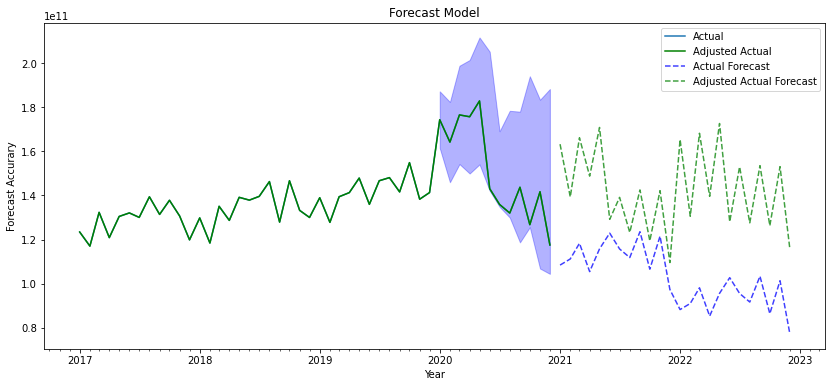

In [12]:
tsfm2.plot("ACUTE")